In [0]:
!pip install polyline
!pip install geopy
!pip install torch
!pip install tqdm
!pip install plotly

In [0]:
import pandas as pd
import numpy as np

from geopy.distance import geodesic
import polyline as pll

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

from sklearn.decomposition import PCA

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/drive/My Drive/hack/train.csv',index_col=0)
df = df.append(pd.read_csv('/content/drive/My Drive/hack/validation.csv',index_col = 0),ignore_index=True)

df_test = pd.read_csv('/content/drive/My Drive/hack/test.csv',index_col=0)
print(df.shape)
df.dropna(axis=0,subset=['onway_latitude','onway_longitude','ready_latitude','ready_longitude','arrived_latitude','arrived_longitude'],inplace=True)
print(df.shape)
df.head()

(739042, 23)
(735834, 23)


,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,RDA,ReadyForCollection,ClientCollected,GoodArrived,ready_latitude,ready_longitude,onway_latitude,onway_longitude,arrived_latitude,arrived_longitude,center_latitude,center_longitude,route,track
0,338,1249.0,1076.0,2020-03-11 20:43:49,45.013191,45.040428,38.981220,39.026501,7.0,8.0,2020-03-11 20:48:52,2020-03-11 20:48:58,2020-03-11 21:06:54,45.012991,38.981120,45.012991,38.981120,45.040108,39.026086,45.040235,38.976080,stvqG{n|lFf@bCN|@NhBH~D?n@MvC_@rES`B??YFWCoAgE...,NaN
1,22402,1822.0,1812.0,2020-02-03 14:27:22,54.735378,54.710651,55.961922,55.822079,15.0,14.0,2020-02-03 14:34:41,2020-02-03 14:35:36,2020-02-03 15:05:48,54.735327,55.961558,54.735515,55.962046,54.710222,55.822577,54.734853,55.957865,ooamI}`qtIXtE??h@_@|@^??lAaN??jA`@??XwD`@_E|@u...,m_qtI}namIWEQASCO?@B@@A@??????????EAKEBKHGDA??...
2,22394,410.0,336.0,2020-02-22 11:15:02,53.529202,53.543640,49.337990,49.351028,2.0,2.0,2020-02-22 11:17:51,2020-02-22 11:18:32,2020-02-22 11:24:08,53.530384,49.339986,53.529227,49.338437,53.543038,49.350991,53.516670,49.416670,u}ueI_hclHwBkGaDqJo@oA]OiCuHK[M{@??Ag@Ie@UYSIU...,wlclHk}ueIGJVH????LJEJ\AtCJbBTHFVB?n@hC\`@iBiA...
3,22406,653.0,558.0,2020-02-26 22:21:28,56.836250,56.863159,60.632580,60.654831,4.0,4.0,2020-02-26 22:30:08,2020-02-26 22:30:16,2020-02-26 22:39:34,56.836830,60.633442,56.836830,60.633442,56.862945,60.654256,56.838633,60.605489,qy{yIshaqJuADoAS_Bb@??UiE??wIfCgOrD}FhB_Bd@??m...,upaqJ{b|yI??^Dl@RFRCTFPNP?PIXGVAH????AA?????A@...
4,22406,518.0,463.0,2020-01-31 07:24:25,56.798431,56.782021,60.632622,60.681702,6.0,6.0,2020-01-31 07:28:34,2020-01-31 07:28:57,2020-01-31 07:36:40,56.798378,60.632567,56.798399,60.632575,56.782251,60.682133,56.838633,60.605489,gmtyI{haqJ\f@??]pA]|@i@t@[Z_@X??c@gDcAoI??aEzB...,NaN


In [0]:
df.columns

Index(['main_id_locality', 'ETA', 'RTA', 'OrderedDate', 'latitude',
       'del_latitude', 'longitude', 'del_longitude', 'EDA', 'RDA',
       'ReadyForCollection', 'ClientCollected', 'GoodArrived',
       'ready_latitude', 'ready_longitude', 'onway_latitude',
       'onway_longitude', 'arrived_latitude', 'arrived_longitude',
       'center_latitude', 'center_longitude', 'route', 'track'],
      dtype='object')

In [0]:
df.dtypes,df.shape

(main_id_locality        int64
 ETA                   float64
 RTA                   float64
 OrderedDate            object
 latitude              float64
 del_latitude          float64
 longitude             float64
 del_longitude         float64
 EDA                   float64
 RDA                   float64
 ReadyForCollection     object
 ClientCollected        object
 GoodArrived            object
 ready_latitude        float64
 ready_longitude       float64
 onway_latitude        float64
 onway_longitude       float64
 arrived_latitude      float64
 arrived_longitude     float64
 center_latitude       float64
 center_longitude      float64
 route                  object
 track                  object
 dtype: object, (735834, 23))

In [0]:
df['OrderedDate'] = pd.to_datetime(df['OrderedDate'],format='%Y-%m-%d %H:%M:%S')
df_test['OrderedDate'] = pd.to_datetime(df_test['OrderedDate'],format='%Y-%m-%d %H:%M:%S')

df['ReadyForCollection'] = pd.to_datetime(df['ReadyForCollection'],format='%Y-%m-%d %H:%M:%S')
df['ClientCollected'] = pd.to_datetime(df['ClientCollected'],format='%Y-%m-%d %H:%M:%S')
df['GoodArrived'] = pd.to_datetime(df['GoodArrived'],format='%Y-%m-%d %H:%M:%S')

df['StartPoint'] = list(zip(df.latitude,df.longitude))
df['EndPoint'] = list(zip(df.del_latitude,df.del_longitude))
df['CenterPoint'] = list(zip(df.center_latitude,df.center_longitude))

df['ReadyPoint'] = list(zip(df.ready_latitude,df.ready_longitude))
df['OnWayPoint'] = list(zip(df.onway_latitude,df.onway_longitude))
df['ArrivedPoint'] = list(zip(df.arrived_latitude,df.arrived_longitude))

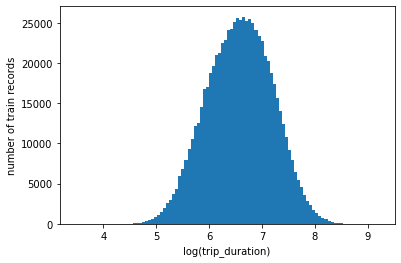

In [0]:
df['log_RTA'] = np.log(df['RTA'].values + 1)
plt.hist(df['log_RTA'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

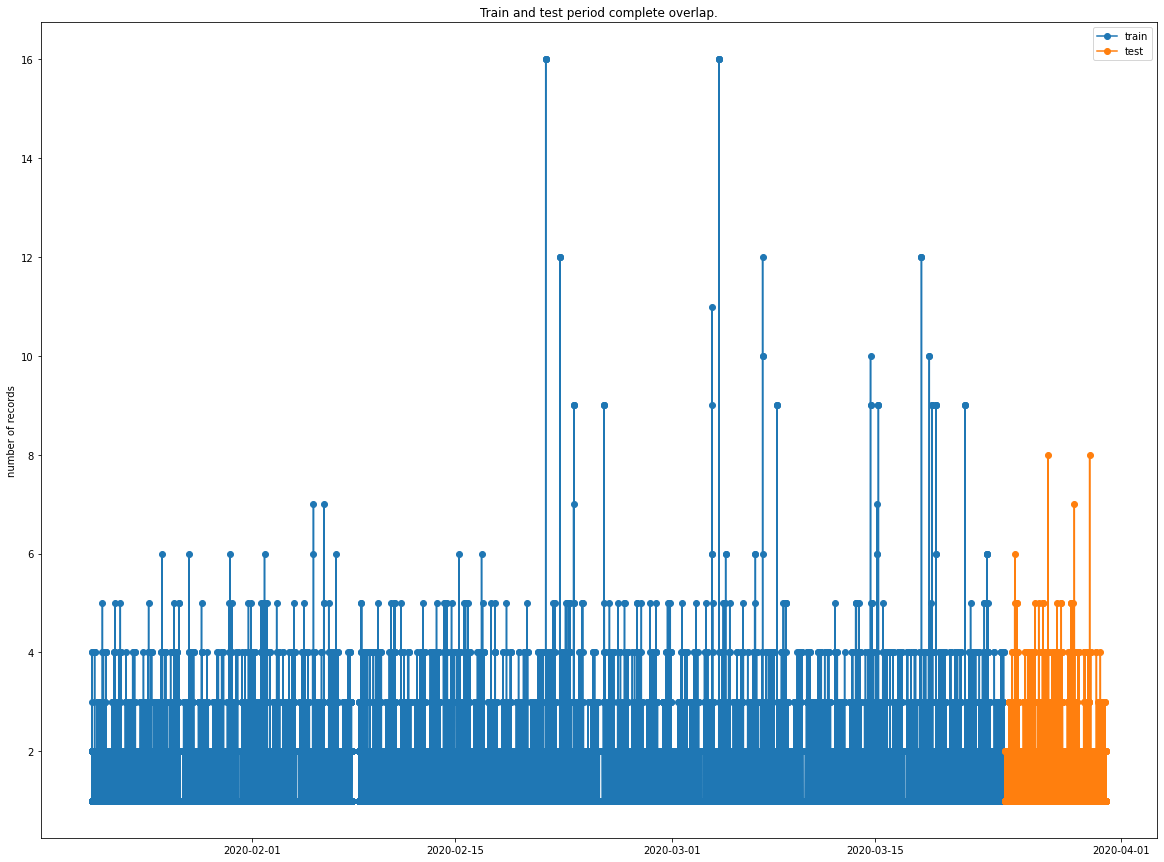

In [0]:
#Date range
fig = plt.figure(figsize=(20,15))
plt.plot(df.groupby('OrderedDate').count()[['main_id_locality']], 'o-', label='train')
plt.plot(df_test.groupby('OrderedDate').count()[['main_id_locality']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

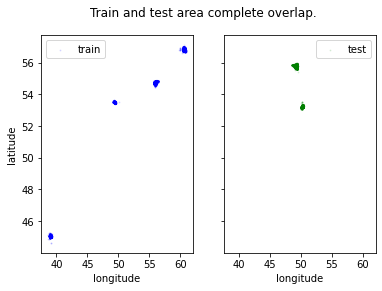

In [0]:
N=40000
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df['longitude'].values[:N], df['latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['longitude'].values[:N], df_test['latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.show()

In [0]:
df.main_id_locality.value_counts(),df_test.main_id_locality.value_counts()

(22406    234476
 338      218935
 22394    142230
 22402    140193
 Name: main_id_locality, dtype: int64, 1078     34922
 22438    24241
 22390    18013
 22430    12762
 Name: main_id_locality, dtype: int64)

In [0]:
coords = np.vstack((df[['latitude', 'longitude']].values,
                    df[['del_latitude', 'del_longitude']].values,
                    df_test[['latitude', 'longitude']].values,
                    df_test[['del_latitude', 'del_longitude']].values))

pca = PCA().fit(coords)
df['pickup_pca0'] = pca.transform(df[['latitude', 'longitude']])[:, 0]
df['pickup_pca1'] = pca.transform(df[['latitude', 'longitude']])[:, 1]
df['dropoff_pca0'] = pca.transform(df[['del_latitude', 'del_longitude']])[:, 0]
df['dropoff_pca1'] = pca.transform(df[['del_latitude', 'del_longitude']])[:, 1]
df_test['pickup_pca0'] = pca.transform(df_test[['latitude', 'longitude']])[:, 0]
df_test['pickup_pca1'] = pca.transform(df_test[['latitude', 'longitude']])[:, 1]
df_test['dropoff_pca0'] = pca.transform(df_test[['del_latitude', 'del_longitude']])[:, 0]
df_test['dropoff_pca1'] = pca.transform(df_test[['del_latitude', 'del_longitude']])[:, 1]

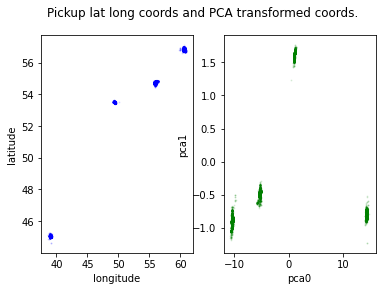

In [0]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(df['longitude'].values[:N], df['latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(df['pickup_pca0'].values[:N], df['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')

plt.show()

In [0]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

df.loc[:, 'distance_haversine'] = haversine_array(df['latitude'].values, df['longitude'].values, df['del_latitude'].values, df['del_longitude'].values)
df.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(df['latitude'].values, df['longitude'].values, df['del_latitude'].values, df['del_longitude'].values)
df.loc[:, 'direction'] = bearing_array(df['latitude'].values, df['longitude'].values, df['del_latitude'].values, df['del_longitude'].values)
df.loc[:, 'pca_manhattan'] = np.abs(df['dropoff_pca1'] - df['pickup_pca1']) + np.abs(df['dropoff_pca0'] - df['pickup_pca0'])

df_test.loc[:, 'distance_haversine'] = haversine_array(df_test['latitude'].values, df_test['longitude'].values, df_test['del_latitude'].values, df_test['del_longitude'].values)
df_test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(df_test['latitude'].values, df_test['longitude'].values, df_test['del_latitude'].values, df_test['del_longitude'].values)
df_test.loc[:, 'direction'] = bearing_array(df_test['latitude'].values, df_test['longitude'].values, df_test['del_latitude'].values, df_test['del_longitude'].values)
df_test.loc[:, 'pca_manhattan'] = np.abs(df_test['dropoff_pca1'] - df_test['pickup_pca1']) + np.abs(df_test['dropoff_pca0'] - df_test['pickup_pca0'])

df.loc[:, 'center_way_latitude'] = (df['latitude'].values + df['del_latitude'].values) / 2
df.loc[:, 'center_way_longitude'] = (df['longitude'].values + df['del_longitude'].values) / 2
df_test.loc[:, 'center_way_latitude'] = (df_test['latitude'].values + df_test['del_latitude'].values) / 2
df_test.loc[:, 'center_way_longitude'] = (df_test['longitude'].values + df_test['del_longitude'].values) / 2

In [0]:
df.loc[:, 'pickup_weekday'] = df['OrderedDate'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['OrderedDate'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['OrderedDate'].dt.hour
df.loc[:, 'pickup_minute'] = df['OrderedDate'].dt.minute
df.loc[:, 'pickup_dt'] = (df['OrderedDate'] - df['OrderedDate'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

df_test.loc[:, 'pickup_weekday'] = df_test['OrderedDate'].dt.weekday
df_test.loc[:, 'pickup_hour_weekofyear'] = df_test['OrderedDate'].dt.weekofyear
df_test.loc[:, 'pickup_hour'] = df_test['OrderedDate'].dt.hour
df_test.loc[:, 'pickup_minute'] = df_test['OrderedDate'].dt.minute
df_test.loc[:, 'pickup_dt'] = (df_test['OrderedDate'] - df_test['OrderedDate'].min()).dt.total_seconds()
df_test.loc[:, 'pickup_week_hour'] = df_test['pickup_weekday'] * 24 + df_test['pickup_hour']

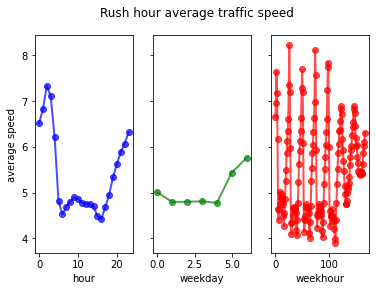

In [0]:
df.loc[:, 'avg_speed_h'] = 1000 * df['distance_haversine'] / df['RTA']
df.loc[:, 'avg_speed_m'] = 1000 * df['distance_dummy_manhattan'] / df['RTA']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

In [0]:
columns_to_train = df_test.columns.drop(['OrderedDate'])

In [0]:
X = df[columns_to_train]
y = np.log(df['RTA'])

In [0]:
X.columns

Index(['main_id_locality', 'ETA', 'latitude', 'del_latitude', 'longitude',
       'del_longitude', 'EDA', 'center_latitude', 'center_longitude',
       'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
       'distance_haversine', 'distance_dummy_manhattan', 'direction',
       'pca_manhattan', 'center_way_latitude', 'center_way_longitude',
       'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour',
       'pickup_minute', 'pickup_dt', 'pickup_week_hour'],
      dtype='object')

# EDA

In [0]:
distances = []
for points in tqdm(list(zip(df['StartPoint'].values,df['EndPoint'].values))):
  distances.append(geodesic(points[0],points[1]).kilometers)

df['Distance'] = distances

100%|██████████| 735834/735834 [02:23<00:00, 5135.45it/s]


In [0]:
df['RDA/EDA'] = df['RDA']/df['EDA']
df['RTA/ETA'] = df['RTA']/df['ETA']
df['Rerun_coeff'] = df['RDA']/df['Distance']

In [0]:
df['route_decoded'] = df.route.apply(lambda x: pll.decode(x))
df['route_len'] = df.route_decoded.apply(lambda x: len(x))

In [0]:
df['AverageSpeed'] = df['EDA']/(df.ETA/60)
df['Weekday'] = df.OrderedDate.dt.weekday
df['DayHour'] = df.OrderedDate.dt.hour

distances = []
for points in tqdm(list(zip(df['StartPoint'].values,df['CenterPoint'].values))):
  distances.append(geodesic(points[0],points[1]).kilometers)

df['DistFromStartToCenter'] = distances

distances = []
for points in tqdm(list(zip(df['EndPoint'].values,df['CenterPoint'].values))):
  distances.append(geodesic(points[0],points[1]).kilometers)

df['DistFromEndToCenter'] = distances

100%|██████████| 735834/735834 [02:26<00:00, 5021.28it/s]


In [0]:
distances = []
for points in tqdm(list(zip(df['OnWayPoint'].values,df['ReadyPoint'].values))):
  distances.append(geodesic(points[0],points[1]).kilometers)

df['DriverButtonFuckUp'] = distances

100%|██████████| 735834/735834 [01:56<00:00, 6331.82it/s]


**BoxPlots**

In [0]:
explore_columns = ['RTA','ETA','RDA','EDA','RDA/EDA','RTA/ETA','route_len','Rerun_coeff','DriverButtonFuckUp']

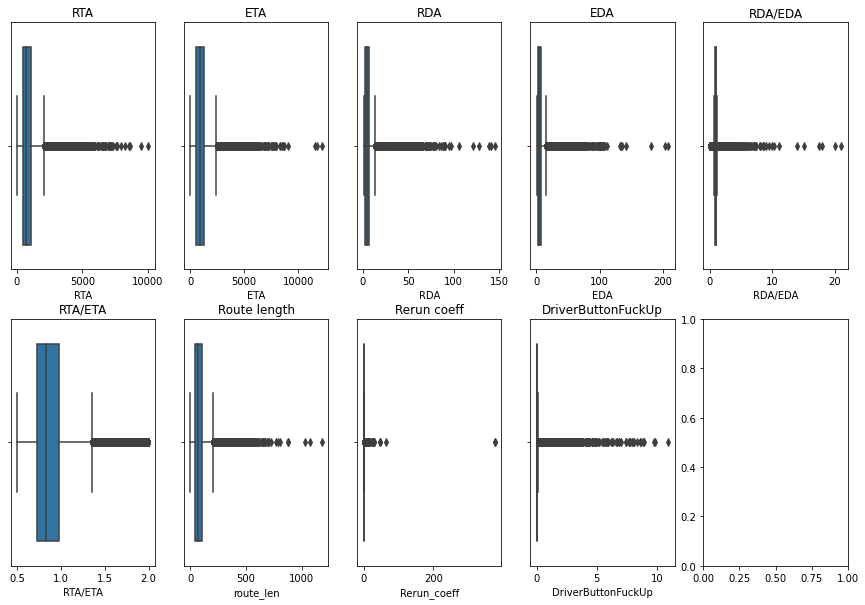

In [0]:
f, axes = plt.subplots(2, 5, sharey=False, figsize=(15, 10))

sns.boxplot(df.RTA,ax=axes[0,0])
sns.boxplot(df.ETA,ax=axes[0,1])
sns.boxplot(df.RDA,ax=axes[0,2])
sns.boxplot(df.EDA,ax=axes[0,3])
sns.boxplot(df['RDA/EDA'],ax=axes[0,4])
sns.boxplot(df['RTA/ETA'],ax=axes[1,0])
sns.boxplot(df.route_len,ax=axes[1,1])
sns.boxplot(df.Rerun_coeff,ax=axes[1,2])
sns.boxplot(df.DriverButtonFuckUp,ax=axes[1,3])

axes[0,0].title.set_text('RTA')
axes[0,1].title.set_text('ETA')
axes[0,2].title.set_text('RDA')
axes[0,3].title.set_text('EDA')
axes[0,4].title.set_text('RDA/EDA')
axes[1,0].title.set_text('RTA/ETA')
axes[1,1].title.set_text('Route length')
axes[1,2].title.set_text('Rerun coeff')
axes[1,3].title.set_text('DriverButtonFuckUp')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


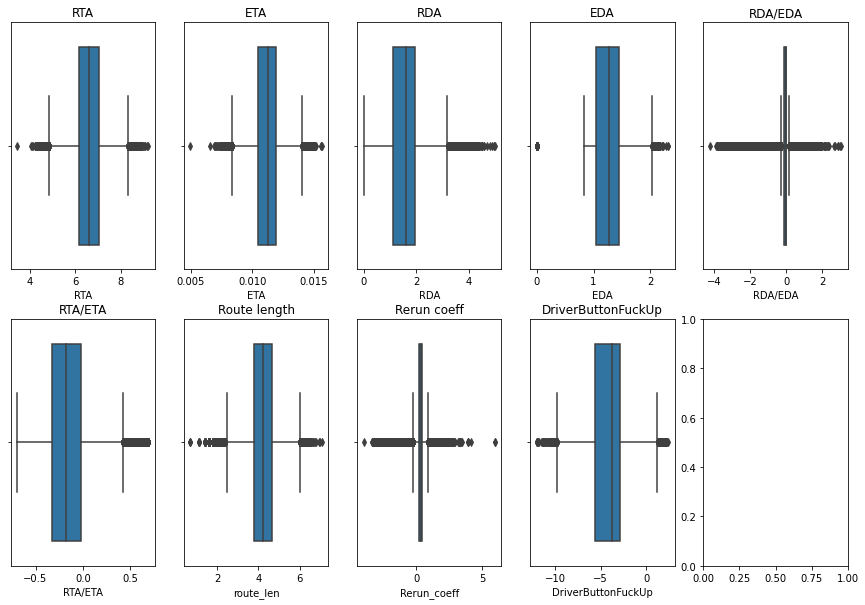

In [0]:
f, axes = plt.subplots(2, 5, sharey=False, figsize=(15, 10))

sns.boxplot(np.log(df.RTA),ax=axes[0,0])
sns.boxplot(np.log(df.ETA)/df.ETA.std(),ax=axes[0,1])
sns.boxplot(np.log(df.RDA),ax=axes[0,2])
sns.boxplot(np.sqrt(np.log(df.EDA)),ax=axes[0,3])
sns.boxplot(np.log(df['RDA/EDA']),ax=axes[0,4])
sns.boxplot(np.log(df['RTA/ETA']),ax=axes[1,0])
sns.boxplot(np.log(df.route_len),ax=axes[1,1])
sns.boxplot(np.log(df.Rerun_coeff),ax=axes[1,2])
sns.boxplot(np.log(df.DriverButtonFuckUp),ax=axes[1,3])

axes[0,0].title.set_text('RTA')
axes[0,1].title.set_text('ETA')
axes[0,2].title.set_text('RDA')
axes[0,3].title.set_text('EDA')
axes[0,4].title.set_text('RDA/EDA')
axes[1,0].title.set_text('RTA/ETA')
axes[1,1].title.set_text('Route length')
axes[1,2].title.set_text('Rerun coeff')
axes[1,3].title.set_text('DriverButtonFuckUp')

In [0]:
for col in explore_columns:
  print(col,':',len(boxplot_stats(np.log(df[col]))[0]['fliers']),',min:', min(boxplot_stats(df[col])[0]['fliers']),',max:',max(boxplot_stats(df[col])[0]['fliers']))

RTA : 1374 ,min: 2092.0 ,max: 10042.0
ETA : 2189 ,min: 2437.0 ,max: 12182.0
RDA : 2401 ,min: 14.0 ,max: 145.0
EDA : 1240 ,min: 16.0 ,max: 208.0
RDA/EDA : 145667 ,min: 0.014705882352941176 ,max: 21.0
RTA/ETA : 13843 ,min: 1.3573806881243062 ,max: 1.9992019154030327
route_len : 2649 ,min: 201 ,max: 1179
Rerun_coeff : 62085 ,min: 0.018518062915213393 ,max: 376.9862257497148
DriverButtonFuckUp : 126715 ,min: 0.13501328485620076 ,max: 10.93771266656333


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Distplots**

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


OverflowError: ignored

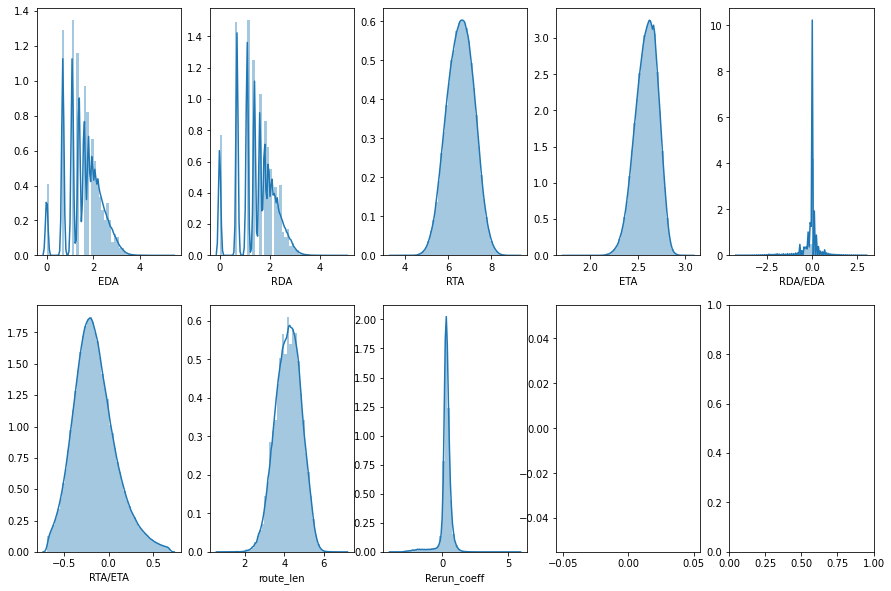

In [0]:
f, axes = plt.subplots(2, 5, sharey=False, figsize=(15, 10))

sns.distplot(np.log(df.EDA),ax=axes[0,0])
sns.distplot(np.log(df.RDA),ax=axes[0,1])
sns.distplot(np.log(df.RTA),ax=axes[0,2])
sns.distplot(np.sqrt(np.log(df.ETA)),ax=axes[0,3])
sns.distplot(np.log(df['RDA/EDA']),ax=axes[0,4])
sns.distplot(np.log(df['RTA/ETA']),ax=axes[1,0])
sns.distplot(np.log(df.route_len),ax=axes[1,1])
sns.distplot(np.log(df.Rerun_coeff),ax=axes[1,2])
sns.distplot(np.log(df.DriverButtonFuckUp),ax=axes[1,3])

axes[0,0].title.set_text('EDA')
axes[0,1].title.set_text('RDA')
axes[0,2].title.set_text('RTA')
axes[0,3].title.set_text('ETA')
axes[0,4].title.set_text('RDA/EDA')
axes[1,0].title.set_text('RTA/ETA')
axes[1,1].title.set_text('Route length')
axes[1,2].title.set_text('Rerun coeff')
axes[1,3].title.set_text('DriverButtonFuckUp')

# Training Model

In [0]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# LightGBM

In [0]:
from lightgbm import LGBMRegressor

In [0]:
LGBMR = LGBMRegressor(random_state=42,n_estimators=200,boosting_type='gbdt')

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3,shuffle=True)

In [0]:
LGBMR.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Model Validation

In [0]:
def mape(true,pred):
  y_true, y_pred = np.array(true.values), pred
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_CV(estimator,X,y):
  prediction = estimator.predict(X)
  return mape(y,prediction)  

In [0]:
prediction_valid = LGBMR.predict(X_valid)

mape(np.exp(y_valid),np.exp(prediction_valid))

15.325795986231777

In [0]:
f1 = pd.DataFrame({'f': list(columns_to_train),
                   'importance': LGBMR.feature_importances_})
f1.sort_values(by='importance')

,f,importance
0,main_id_locality,0
8,center_longitude,0
7,center_latitude,0
20,pickup_hour_weekofyear,30
16,pca_manhattan,70
13,distance_haversine,97
14,distance_dummy_manhattan,100
19,pickup_weekday,110
15,direction,129
22,pickup_minute,145


In [0]:
LGBMR.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
np.mean(cross_val_score(LGBMR,X,y,scoring=mape_CV,cv=KFold(shuffle=True)))

2.369420071909242

# Test Submission

In [0]:
X_test = df_test[columns_to_train]

In [0]:
prediction_test = np.exp(LGBMR.predict(X_test))

In [0]:
sub = pd.DataFrame({'Id':[i for i in range(df_test.shape[0])],'Prediction':prediction_test})
sub.head(),sub.shape

(   Id   Prediction
 0   0   890.724809
 1   1   692.882250
 2   2   351.967336
 3   3   705.884004
 4   4  1273.906847, (89938, 2))

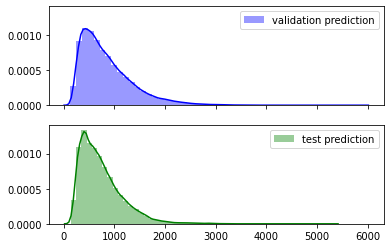

In [0]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(np.exp(prediction_valid), ax=ax[0], color='blue', label='validation prediction')
sns.distplot(prediction_test, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

In [0]:
sub.to_csv('/content/drive/My Drive/hack/submission.csv',index=False)